## Import Libraries

In [127]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [128]:
df = pd.read_csv("./Lower player.csv")

In [129]:
df.shape

(5912, 19)

In [130]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,1,Manchester United,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000
1,2,Manchester United,Goalkeeper,188.0,37.0,4,0.0,0.0,0.000000,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000


In [131]:
df.drop(columns='Unnamed: 0' , inplace = True)

## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [132]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value


In [133]:
# Completeness
df.isnull().sum()

team                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [134]:
numeric_col = [col for col in df.columns if df[col].dtype != "object"]
categorical_col = [col for col in df.columns if df[col].dtype == "object"]

In [135]:
# for i in categorical_col:
#     print(df[i].value_counts())

In [136]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['current_value'].quantile(0.35)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Cheap_Price'
    elif price < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

# Apply the function to create a new column
df['sale_price_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['sale_price_category'].value_counts())

sale_price_category
Good_Price     2255
Cheap_Price    1946
High_Price     1711
Name: count, dtype: int64


#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [137]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,highest_value,sale_price_category
0,Manchester United,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,22000000,High_Price
1,Manchester United,Goalkeeper,188.0,37.0,4,0.0,0.0,0.000000,0.0,0.0,0.616438,0.924658,292,697,84,4,6000000,Good_Price


In [138]:
categorical_col = ['team' , 'position']

In [139]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_col)

In [140]:
df.shape

(5912, 403)

In [141]:
encoder = LabelEncoder()
df['sale_price_category'] = encoder.fit_transform(df['sale_price_category'])  

#### 3. Feature selection

In [142]:
correlation = df.corr()
correlation['sale_price_category'].sort_values(ascending=False)

sale_price_category    1.000000
highest_value          0.381909
minutes played         0.306681
appearance             0.305590
games_injured          0.233946
                         ...   
position_Defender     -0.090184
position_Attack       -0.115159
position_midfield     -0.133761
goals conceded        -0.143927
position_Goalkeeper   -0.209644
Name: sale_price_category, Length: 403, dtype: float64

In [143]:
# Set the correlation threshold
threshold = 0.3  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['sale_price_category']) > threshold]['sale_price_category'].index
selected_features

Index(['appearance', 'minutes played', 'highest_value', 'sale_price_category'], dtype='object')

In [144]:
df = df[selected_features]

#### 4. Prepare train and test data

In [145]:
# Prepare data
X = df.drop(['sale_price_category'], axis=1)
y = df['sale_price_category']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# # sacle the data
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [146]:
X.shape

(5912, 3)

## Buliding the Model

In [147]:
model = SVC()

In [148]:
param_grid = {
    'kernel': [
             # 'linear',
               'rbf',
             # 'poly'
              ],   # Regularization strength
    'C':[0, 2, 5, 10, 15, 20, 25],
    'gamma': [1,2,6]
}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

## Train the Model

In [149]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0, 2, 5, 10, 15, 20, 25], 'gamma': [1, 2, 6],
                         'kernel': ['rbf']},
             scoring='f1_macro', verbose=1)

In [150]:
grid_search.best_params_

{'C': 2, 'gamma': 1, 'kernel': 'rbf'}

In [151]:
model = grid_search.best_estimator_

## Test the Model

In [152]:
# Predict and evaluate the model
y_pred = model.predict(X_test)

## Evaluating the Model 

In [153]:
# our benchmark model
base_model = round(df['sale_price_category'].value_counts()[1]/df.shape[0]*100, 2)
base_model

38.14

1. Accuracy

In [154]:
# Evaluate the model
accuracy_test = accuracy_score(y_test, y_pred)
print('Test accuracy' ,accuracy_test*100)

y_pred_train = model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Train accuracy' ,accuracy_train*100)


Test accuracy 47.16821639898563
Train accuracy 98.87925565658702


2. Precision

In [155]:
# Calculate Precision
precision_test = precision_score(y_test, y_pred, average='macro')
print(f"Test Precision: {precision_test:.2f}")

y_pred_train = model.predict(X_train)
precision_train = precision_score(y_train, y_pred_train,average='macro')
print(f"Train Precision: {precision_train:.2f}")

Test Precision: 0.71
Train Precision: 0.99


3. Recall

In [156]:
# Calculate Recall
recall_test = recall_score(y_test, y_pred, average='macro')
print(f"Test Recall: {recall_test:.2f}")

y_pred_train = model.predict(X_train)
recall_train = recall_score(y_train, y_pred_train, average='macro')
print(f"Train Recall: {recall_train:.2f}")

Test Recall: 0.43
Train Recall: 0.99


4. F1 Score

In [157]:
# Calculate F1 Score
f1_test = f1_score(y_test, y_pred, average='macro')
print(f"Test F1 Score: {f1_test:.2f}")

y_pred_train = model.predict(X_train)
f1_train = f1_score(y_train, y_pred_train, average='macro')
print(f"Train F1 Score: {f1_train:.2f}")

Test F1 Score: 0.36
Train F1 Score: 0.99


#### Predictions vs. Real Values

In [158]:
predictions = model.predict(X_test)

In [159]:
Real_Values = np.array(y_test)
#Real_Values

#### Residual Histogram

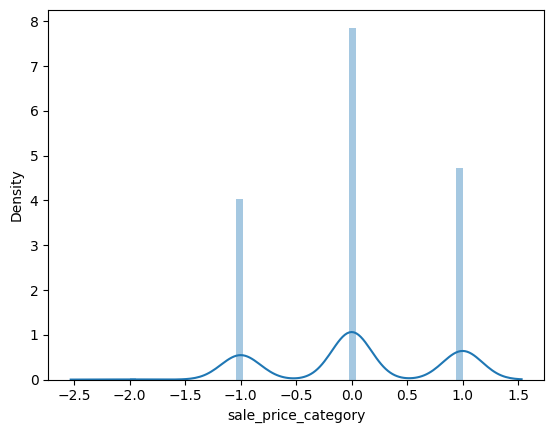

In [160]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution

In [161]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[102, 284,   2],
       [  5, 441,   3],
       [  0, 331,  15]], dtype=int64)